In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tft-bax/df_bax_cleaned_till_outliers.csv


File loaded successfully.

Data preparation complete.

Model instantiated successfully.

--- Starting Model Training ---
Epoch [5/50], Loss: 0.003378
Epoch [10/50], Loss: 0.001890
Epoch [15/50], Loss: 0.001541
Epoch [20/50], Loss: 0.001155
Epoch [25/50], Loss: 0.001043
Epoch [30/50], Loss: 0.001405
Epoch [35/50], Loss: 0.000902
Epoch [40/50], Loss: 0.000743
Epoch [45/50], Loss: 0.000793
Epoch [50/50], Loss: 0.000664
--- Training Complete ---

Test Root Mean Squared Error (RMSE): 98.4486


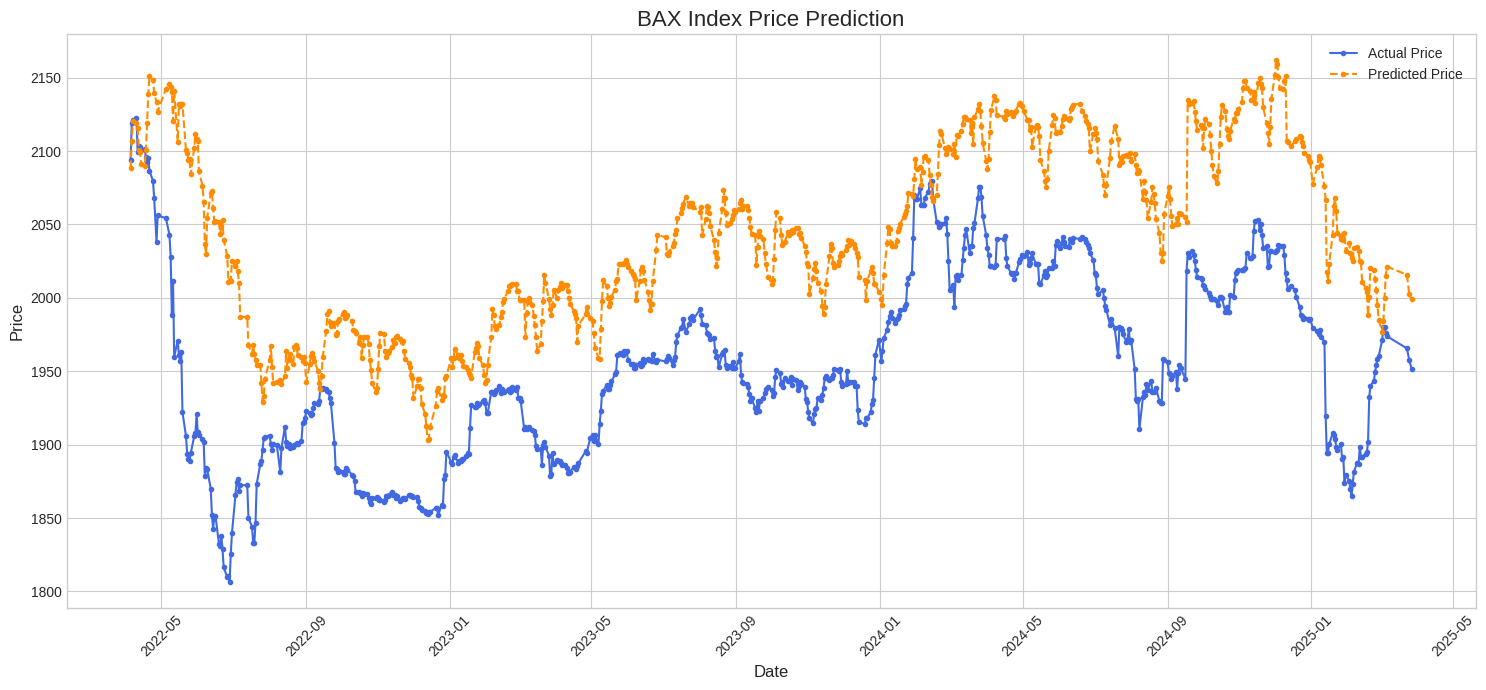

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --- Step 1: Load and Preprocess Data ---

# Load the dataset from the uploaded file
try:
    df = pd.read_csv('/kaggle/input/tft-bax/df_bax_cleaned_till_outliers.csv')
    print("File loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'df_bax_cleaned_till_outliers.csv' was not found.")
    df = pd.DataFrame() 

if not df.empty:
    # --- Data Cleaning and Feature Selection ---
    if 'Vol.' in df.columns:
        df.rename(columns={'Vol.': 'Volume'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    features_to_keep = ['Price', 'Volume', 'Change %']
    df = df[features_to_keep]

    # --- Step 2: Scale Data and Create Sequences ---

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    sequence_length = 60
    X, y = [], []

    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length, 0])

    X, y = np.array(X), np.array(y)

    # --- Data Splitting ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    # Store original test dates for plotting
    test_dates = df.index[len(df) - len(y_test):]


    # --- Create PyTorch Tensors and DataLoaders ---
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("\nData preparation complete.")

    # --- Step 3: Define the Transformer Model ---

    class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, max_len=5000):
            super(PositionalEncoding, self).__init__()
            self.dropout = nn.Dropout(p=dropout)
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0).transpose(0, 1)
            self.register_buffer('pe', pe)

        def forward(self, x):
            x = x + self.pe[:x.size(0), :]
            return self.dropout(x)

    class TimeSeriesTransformer(nn.Module):
        def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
            super(TimeSeriesTransformer, self).__init__()
            self.input_embedding = nn.Linear(input_dim, d_model)
            self.pos_encoder = PositionalEncoding(d_model, dropout)
            encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
            self.decoder = nn.Linear(d_model, 1)

        def forward(self, src):
            src = self.input_embedding(src)
            src = self.pos_encoder(src)
            output = self.transformer_encoder(src)
            output = self.decoder(output[:, -1, :])
            return output

    # --- Model Hyperparameters ---
    input_dim = X_train_tensor.shape[2]
    d_model = 64
    nhead = 4
    num_encoder_layers = 3
    dim_feedforward = 128
    dropout = 0.1

    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)
    print("\nModel instantiated successfully.")

    # --- Step 4: Train the Model ---
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50

    print("\n--- Starting Model Training ---")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            output = model(sequences)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    print("--- Training Complete ---")

    # --- Step 5: Evaluate the Model and Visualize Results ---
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            output = model(sequences)
            predictions.extend(output.numpy().flatten())
            actuals.extend(targets.numpy().flatten())

    # --- Inverse Transform to Original Scale ---
    # Create a dummy array with the same number of features as the original scaler
    num_features = scaled_data.shape[1]
    
    # Reshape predictions and actuals for inverse transform
    predictions_rescaled = np.zeros((len(predictions), num_features))
    predictions_rescaled[:, 0] = predictions
    predictions_rescaled = scaler.inverse_transform(predictions_rescaled)[:, 0]

    actuals_rescaled = np.zeros((len(actuals), num_features))
    actuals_rescaled[:, 0] = actuals
    actuals_rescaled = scaler.inverse_transform(actuals_rescaled)[:, 0]

    # --- Calculate RMSE ---
    rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
    print(f'\nTest Root Mean Squared Error (RMSE): {rmse:.4f}')

    # --- Visualize the Predictions ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    plt.plot(test_dates, actuals_rescaled, label='Actual Price', color='royalblue', marker='.', linestyle='-')
    plt.plot(test_dates, predictions_rescaled, label='Predicted Price', color='darkorange', marker='.', linestyle='--')
    plt.title('BAX Index Price Prediction', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Indication that model needs more features as markets are not only based on price but also dependent on other features as well.